In [2]:
%matplotlib notebook

In [3]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/4DCT/lib/pkgconfig'

In [4]:
import sys, os
import numpy as np
import scipy as sp

import fenics as fe
import fenics_adjoint as fa
from fenics import grad, dot, dx, ds

import torch
import torch.nn.functional as F
import torch_fenics

import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import xarray as xr
import hvplot.xarray

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv001
--------------------------------------------------------------------------


PDE problem:

\begin{align*}
    \nabla^2 \mathbf{u} &= \mathbf{\mu} \quad\,\, x \in \Omega \\
    \mathbf{u} &= \mathbf{u}_{b} \quad x \in \delta\Omega
\end{align*}

Dataset generation:

\begin{align*}
    \textbf{a} &\sim p(\bf a) \\
    \mu &\sim p(\mu|\bf a) \\
    \mathbf{u} &= \text{solvePDE}(\mu, \mathbf{u}_b)
\end{align*}

Model training:

\begin{align*}
    \hat{\mu} &= \text{DNN}(\mathbf{a};\theta) \\
    \hat{\bf u} &= \text{solvePDE}(\hat{\mu}, \mathbf{u}_b) \\
    \theta^* &= \operatorname{argmin}_\theta \| \mathbf{u} - \hat{\bf u} \|
\end{align*}

# 1) Randomly sample smooth 1D functions

In [6]:
def plot1d(x, *args):
    n_plots = len(args)
    fig, ax = plt.subplots(n_plots, 1, figsize=(8, 2*n_plots), squeeze=False)
    for i, y in enumerate(args):
        for y_ in y:
            ax[i,0].plot(x, y_)

<IPython.core.display.Javascript object>


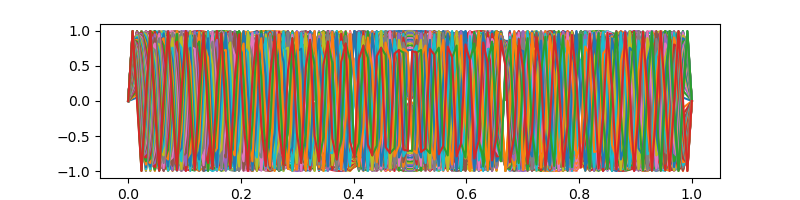

<IPython.core.display.Javascript object>


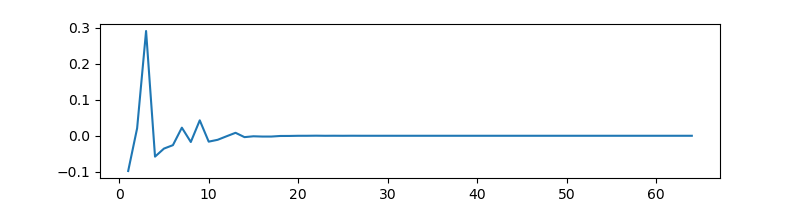

<IPython.core.display.Javascript object>


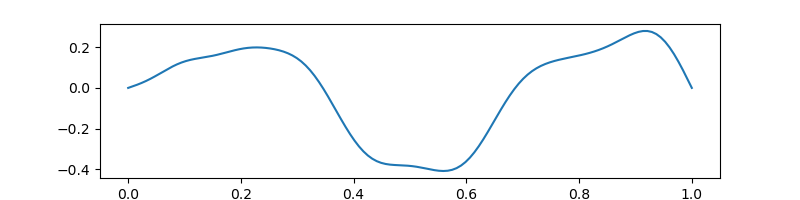

<IPython.core.display.Javascript object>


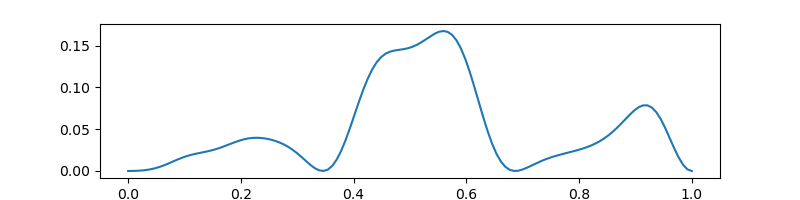

In [26]:
n_samples = 1
n_nodes = 128
n_freqs = n_nodes // 2

# construct Fourier basis
x = np.linspace(0, 1, n_nodes)
f = np.arange(1, n_freqs + 1)
phi = np.sin(np.pi * np.outer(f, x))

# randomly sample Fourier coefficients A[f] ~ N(0,r^f)
#   r controls exponential decay of higher frequencies
#   lower r -> smoother function
# amplitude of resulting function is a geometric series
#   that converges to r / (1 - r) (?)
# we normalize by this to control the output scale
r = 0.7
A = np.random.normal(0, 1, (n_samples, n_freqs)) * (r**f)
A /= r / (1 - r)

a = A @ phi
mu_range = (0, 1)
mu = (mu_range[1] - mu_range[0]) * a**2 + mu_range[0]

plot1d(x, phi)
plot1d(f, A)
plot1d(x, a)
plot1d(x, mu)

# 2) Solve PDE to generate ground truth

In [27]:
class PDESolver(torch_fenics.FEniCSModule):
    
    def __init__(self, n_nodes):
        super().__init__()
        
        # create function space
        n_elements = n_nodes - 1
        mesh = fe.UnitIntervalMesh(n_elements)
        self.V = fe.FunctionSpace(mesh, 'P', 1)
        
        # create trial and test functions
        u = fe.TrialFunction(self.V)
        self.v = fe.TestFunction(self.V)
        
        # construct bilinear form
        self.a = fe.inner(fe.grad(u), fe.grad(self.v)) * fe.dx
        
    def solve(self, f, ub):
        
        # construct linear form
        L = f * self.v * fe.dx
        
        # construct boundary condition
        bc = fa.DirichletBC(self.V, ub, 'on_boundary')
        
        # solve the Poisson equation
        u = fa.Function(self.V)
        fa.solve(self.a == L, u, bc)
        
        return u
    
    def input_templates(self):
        return fa.Function(self.V), fa.Constant(0)

pde_solver = PDESolver(n_nodes)

In [28]:
%%time
print('solving forward problem')

a  = torch.tensor(a, dtype=torch.float64)
mu = torch.tensor(mu, requires_grad=True, dtype=torch.float64)
ub = torch.zeros(n_samples, 1, requires_grad=True, dtype=torch.float64)
u  = pde_solver.forward(mu, ub)
u.shape

solving forward problem
CPU times: user 4.52 ms, sys: 764 µs, total: 5.28 ms
Wall time: 5.36 ms


torch.Size([1, 128])

In [29]:
%%time
print('solving adjoint problem')
L = (u.abs()**2).sum()
L.backward()
dL_dmu = mu.grad
dL_dub = ub.grad
dL_dmu.shape, dL_dub.shape

solving adjoint problem
CPU times: user 11.6 ms, sys: 1.98 ms, total: 13.5 ms
Wall time: 13.7 ms


(torch.Size([1, 128]), torch.Size([1, 1]))

<IPython.core.display.Javascript object>


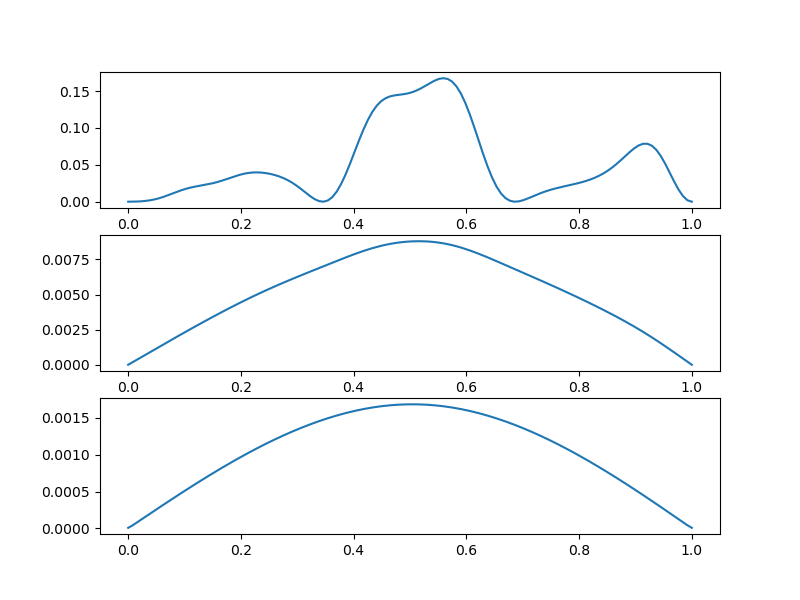

In [30]:
plot1d(
    x,
    mu.detach().numpy(),
    u.detach().numpy(),
    dL_dmu.detach().numpy()
)

# 3) Train neural network with PDE solver

In [31]:
identity = lambda x: x

class PDEDataset(torch.utils.data.Dataset):

    def __init__(self, a, mu, u, ub, device):
        super().__init__()
        self.a = a
        self.mu = mu
        self.u = u
        self.ub = ub
        self.device = device
        
    @classmethod
    def generate(cls, n_samples, n_nodes, r=0.7, mu_range=(0, 1), device='cuda'):

        # construct Fourier basis
        n_freqs = n_nodes // 2
        x = np.linspace(0, 1, n_nodes)
        f = np.arange(1, n_freqs + 1)
        phi = np.sin(np.pi * np.outer(f, x))

        # sample random Fourier coefficients and normalize
        A = np.random.normal(0, 1, (n_samples, n_freqs)) * (r**f)
        A /= r / (1 - r)

        # compute a and mu from sampled Fourier coefficients
        a = A @ phi
        mu = (mu_range[1] - mu_range[0]) * a**2 + mu_range[0]
        
        # create boundary conditions and solve forward PDE       
        a  = torch.tensor(a, dtype=torch.float64)
        mu = torch.tensor(mu, dtype=torch.float64)
        ub = torch.zeros(n_samples, 1, dtype=torch.float64)
        u  = PDESolver(n_nodes).forward(mu, ub)
        
        return cls(a, mu, u, ub, device)

    def __len__(self):
        return len(self.a)

    def __getitem__(self, idx):
        return (
            torch.as_tensor(self.a[idx]).to(self.device, dtype=torch.float32),
            torch.as_tensor(self.mu[idx]).to(self.device, dtype=torch.float32),
            torch.as_tensor(self.u[idx]).to(self.device, dtype=torch.float32),
            torch.as_tensor(self.ub[idx]).to(self.device, dtype=torch.float32)
        )
    
    def select(self,inds):
        a  = [self.a[i]  for i in inds]
        mu = [self.mu[i] for i in inds]
        u  = [self.u[i]  for i in inds]
        ub = [self.ub[i] for i in inds]
        return PDEDataset(a, mu, u, ub, self.device)
    
    def sample(self, n, seed=None):
        np.random.seed(seed)
        shuffled_inds = np.random.permutation(len(self))
        sampled_inds = shuffled_inds[:n]
        return self.select(sampled_inds)
    
    def split(self, n, seed=None):
        np.random.seed(seed)
        shuffled_inds = np.random.permutation(len(self))
        train_inds, test_inds = np.split(shuffled_inds, [n])
        train_data = self.select(train_inds)
        test_data = self.select(test_inds)
        return train_data, test_data 

dataset = PDEDataset.generate(n_samples=10000, n_nodes=128, device='cuda')
(a, mu, u, ub) = next(iter(torch.utils.data.DataLoader(dataset, batch_size=10)))
a.shape

torch.Size([10, 128])

<IPython.core.display.Javascript object>


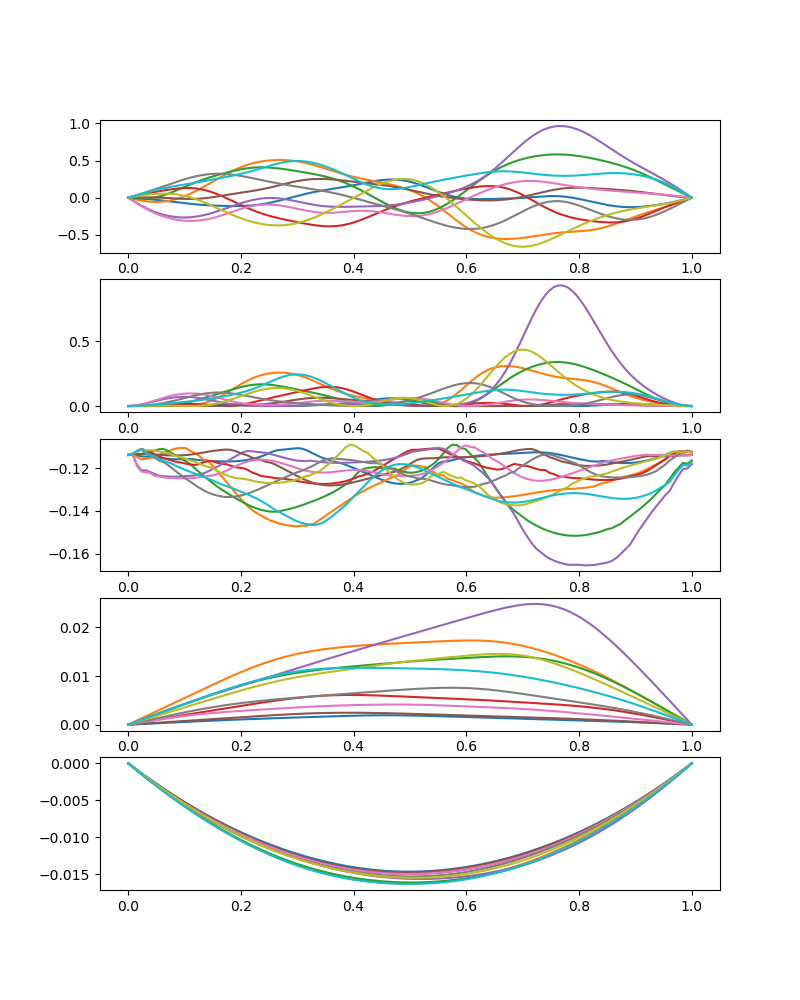

In [32]:
class PDENet(torch.nn.Module):

    def __init__(self, n_nodes, n_filters, kernel_size, activ_fn):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(1, n_filters, kernel_size, padding=kernel_size//2, padding_mode='reflect')
        self.conv2 = torch.nn.Conv1d(n_filters, n_filters, kernel_size, padding=kernel_size//2, padding_mode='reflect')
        self.conv3 = torch.nn.Conv1d(n_filters, 1, kernel_size, padding=kernel_size//2, padding_mode='reflect')
        try:
            self.activ_fn = getattr(torch.nn.functional, activ_fn)
        except AttributeError:
            self.activ_fn = getattr(torch, activ_fn)
        self.solve_pde = PDESolver(n_nodes)

    def forward(self, a, ub):
        a = a.unsqueeze(1)
        z1 = self.activ_fn(self.conv1(a))
        z2 = self.activ_fn(self.conv2(z1))
        mu = self.conv3(z2)[:,0,:]
        u  = self.solve_pde(
            mu.to('cpu', dtype=torch.float64),
            ub.to('cpu', dtype=torch.float64)
        ).to('cuda', dtype=torch.float32)
        return mu, u


model = PDENet(n_nodes=128, n_filters=16, kernel_size=5, activ_fn='leaky_relu').cuda()
mu_hat, u_hat = model.forward(a, ub)
plot1d(
    x,
    a.detach().cpu().numpy(),
    mu.detach().cpu().numpy(),
    mu_hat.detach().cpu().numpy(),
    u.detach().cpu().numpy(),
    u_hat.detach().cpu().numpy(),
)

In [41]:
class TrainingPlot(object):
    '''
    Interactive training plot.
    '''
    def __init__(self):
        
        # create subplots for loss and accuracy
        self.fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].set_ylabel('u_loss')
        ax[1].set_ylabel('mu_loss')
        for ax_ in ax:
            ax_.set_axisbelow(True)
            ax_.grid(linestyle=':')
            ax_.set_xlabel('iteration')
        self.fig.tight_layout()
        
        # store data and artists for interactive ploting
        self.data = pd.DataFrame(columns=['iter', 'phase', 'u_loss', 'mu_loss'])

        self.train_u_loss_line = ax[0].plot([], [], label='train')[0]
        self.test_u_loss_line  = ax[0].plot([], [], label='test')[0]
        self.train_mu_loss_line = ax[1].plot([], [], label='train')[0]
        self.test_mu_loss_line  = ax[1].plot([], [], label='test')[0]
        
    def draw(self, pad=1e-8):
        ax = self.fig.get_axes()
        ax[0].set_xlim(0, self.data.iter.max() * 1.1 + pad)
        ax[0].set_ylim(0, self.data.u_loss.max() * 1.1 + pad)
        ax[1].set_xlim(0, self.data.iter.max() * 1.1 + pad)
        ax[1].set_ylim(0, self.data.mu_loss.max() * 1.1 + pad)
        self.fig.canvas.draw()
        
    def update_train(self, iteration, u_loss, mu_loss):
        self.data.loc[len(self.data)] = [iteration, 'train', u_loss.item(), mu_loss.item()]
        
        data = self.data.groupby(['phase', 'iter']).mean()
        train = data.loc['train'].reset_index()
        if isinstance(train, pd.Series): # need > 1 rows
            return
        
        self.train_u_loss_line.set_xdata(train.iter)
        self.train_u_loss_line.set_ydata(train.u_loss)

        self.train_mu_loss_line.set_xdata(train.iter)
        self.train_mu_loss_line.set_ydata(train.mu_loss)

        self.draw()
        
    def update_test(self, iteration, u_loss, mu_loss):
        self.data.loc[len(self.data)] = [iteration, 'test', u_loss.item(), mu_loss.item()]
        
        data = self.data.groupby(['phase', 'iter']).mean()
        test = data.loc['test'].reset_index()
        if isinstance(test, pd.Series): # need > 1 rows
            return
        
        self.test_u_loss_line.set_xdata(test.iter)
        self.test_u_loss_line.set_ydata(test.u_loss) 
        
        self.test_mu_loss_line.set_xdata(test.iter)
        self.test_mu_loss_line.set_ydata(test.mu_loss)
        
        self.draw()

In [42]:
def train(dataset, model, optim, batch_size, n_epochs, verbose=False):

    # split dataset and create data loaders
    train_set, test_set = dataset.split(n=int(0.9 * len(dataset)), seed=0)
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=True
    )
    
    # set model to training mode
    model.train()
    
    # loss function
    loss_fn = F.mse_loss
    
    # setup training plot
    plot = TrainingPlot()
   
    if verbose:
        epoch_iterator = range(n_epochs)
    else:
        epoch_iterator = tqdm.tqdm(range(n_epochs), file=sys.stdout)
    
    # start training loop
    iteration = 0
    for epoch in epoch_iterator:
        if verbose:
            print(f'Epoch {epoch+1}/{n_epochs}')
            print('Training...')
            train_iterator = tqdm.tqdm(train_loader, file=sys.stdout)
        else:
            train_iterator = train_loader
    
        for i, (a, mu, u, ub) in enumerate(train_iterator):
            mu_hat, u_hat = model.forward(a, ub)
            u_loss = loss_fn(u_hat, u)
            mu_loss = loss_fn(mu_hat, mu)
            plot.update_train(iteration, u_loss, mu_loss)
            u_loss.backward()
            optim.step()
            iteration += 1
        
        if verbose:
            print('Validating...')
            test_iterator = tqdm.tqdm(test_loader, file=sys.stdout)
        else:
            test_iterator = test_loader
    
        for i, (a, mu, u, ub) in enumerate(test_iterator):
            with torch.no_grad():
                mu_hat, u_hat = model.forward(a, ub)
                u_loss = loss_fn(u_hat, u)
                mu_loss = loss_fn(mu_hat, mu)
                plot.update_test(iteration, u_loss, mu_loss)

<IPython.core.display.Javascript object>


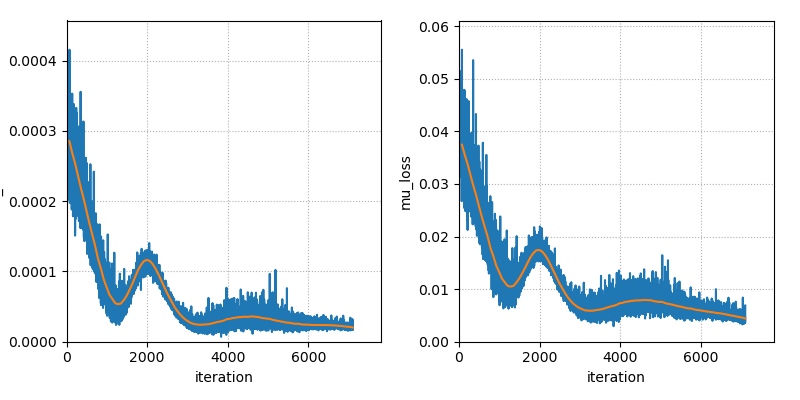

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
optim = torch.optim.Adam(model.parameters(), lr=1e-5)
train(dataset, model, optim, batch_size=128, n_epochs=100, verbose=False)

In [45]:
test_set = PDEDataset.generate(n_samples=100, n_nodes=128, device='cuda')

<IPython.core.display.Javascript object>


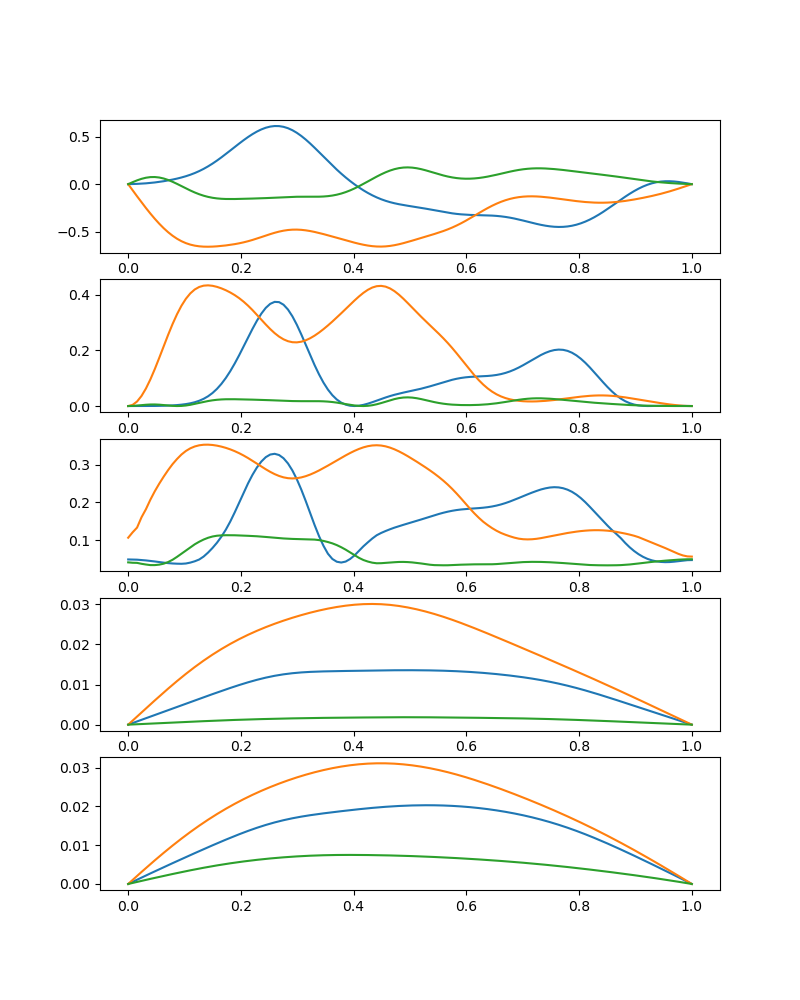

In [52]:
a, mu, u, ub = next(iter(torch.utils.data.DataLoader(test_set, batch_size=3, shuffle=True)))
mu_hat, u_hat = model.forward(a, ub)

plot1d(
    x,
    a.detach().cpu().numpy(),
    mu.detach().cpu().numpy(),
    mu_hat.detach().cpu().numpy(),
    u.detach().cpu().numpy(),
    u_hat.detach().cpu().numpy(),
)

## Adjoint method derivation

A PDE constraint implicitly defines $\mathbf{u}(\mu)$:
$$
\begin{align*}
    \mathbf{r}(\mathbf{u};\mu) = 0
\end{align*}
$$

Loss function
$$
\begin{align*}
    L(\mathbf{u},\mu)
\end{align*}
$$

Loss gradient
$$
\begin{align*}
    dL &= \frac{\partial L}{\partial \mu} d\mu + \frac{\partial L}{\partial \mathbf{u}} d \mathbf{u} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} + \frac{\partial L}{\partial \mathbf{u}} \frac{d\mathbf{u}}{d\mu}
\end{align*}
$$

Assume that $\mathbf{r} = 0$
$$
\begin{align*}
    d\mathbf{r} &= 0 \\ 
    \frac{\partial \bf r}{\partial \bf u} d\mathbf{u} + \frac{\partial \bf r}{\partial \mu} d\mu &= 0 \\
    \frac{\partial \bf r}{\partial \bf u} \frac{d \bf u}{d \mu} + \frac{\partial \bf r}{\partial \mu} &= 0 \\
    \frac{\partial \bf r}{\partial \bf u} \frac{d \bf u}{d \mu} &= -\frac{\partial \bf r}{\partial \mu} \\
    \frac{d \bf u}{d \mu} &= -\frac{\partial \bf r}{\partial \bf u}^{-1} \frac{\partial \bf r}{\partial \mu}
\end{align*}
$$

This result is part of the implicit function theorem.

Then:
$$
\begin{align*}
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} + \frac{\partial L}{\partial \bf u} \frac{d \bf u}{d \mu} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \frac{\partial L}{\partial \bf u} \left( \frac{\partial \bf r}{\partial \bf u} ^{-1} \frac{\partial \bf r}{\partial \mu} \right) \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \left( \frac{\partial L}{\partial \bf u} \frac{\partial \bf r}{\partial \bf u} ^{-1} \right) \frac{\partial \bf r}{\partial \mu} \\
\end{align*}
$$

Direct method:

$$
\begin{align*}
    \Phi &= \frac{\partial \bf r}{\partial \bf u} ^{-1} \frac{\partial \bf r}{\partial \mu} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \frac{\partial L}{\partial \bf u} \Phi \\
    \operatorname{solve} \, \frac{\partial \bf r}{\partial \bf u} \Phi &= \frac{\partial \bf r}{\partial \mu}
\end{align*}
$$

Adjoint method:

$$
\begin{align*}
    \Psi^\top &= \frac{\partial L}{\partial \bf u} \frac{\partial \bf r}{\partial \bf u} ^{-1} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \Psi^\top \frac{\partial \bf r}{\partial \mu} \\
    \operatorname{solve} \, \frac{\partial \bf r}{\partial \bf u}^\top \Psi &= \frac{\partial L}{\partial \bf u}^\top
\end{align*}
$$

In either case, the output is $\frac{d L}{d \mu}$.

In [ ]:
class ImplicitPDELayer(object):

    def forward(self, mu):
        u = solve_pde(mu)
        return u

    def backward(self, dL_du, dL_dmu, dr_du, dr_dmu, method='adjoint'):
    
        if method == 'direct':
            phi = torch.linalg.solve(dr_du, dr_dmu)
            grad = dL_dmu - dL_du @ phi
    
        elif method == 'adjoint':
            psi = torch.linalg.solve(dr_du.T, dL_du.T)
            grad = dL_dmu - psi.T @ dr_dmu
            
        return grad
